# Community Detection Demo — Label Propagation on Facebook Page Graph

This notebook provides an example of using label propagation for community detection on a social network. The goal is to apply the `LabelPropagation` implementation from the `rice2025` package to a subgraph of the Facebook page–page network and visualize the resulting communities.


## What this notebook is about

Label propagation is a simple, scalable algorithm for **unsupervised community detection** in graphs. Each node starts with a unique label, and labels are iteratively updated based on the most common label among neighbors. Dense regions of the graph tend to converge to a common label, which corresponds to a community.

In this notebook, I:

- Load an edge list for the Facebook page–page graph  
- Build a subgraph with 500 highly connected nodes  
- Construct a dense adjacency matrix for this subgraph  
- Run the label propagation algorithm implemented in `rice2025`  
- Visualize the communities using a spectral embedding of the graph Laplacian  
- Summarize community sizes and comment on stability across random seeds  


## Dataset: `musae_facebook_edges.csv`

The file `musae_facebook_edges.csv` contains an edge list for an undirected Facebook page–page graph. Each row specifies an edge between two node IDs:

- `id_1` – node at one end of the edge (integer, zero-based)  
- `id_2` – node at the other end of the edge (integer, zero-based)  

The full graph has tens of thousands of nodes, so constructing a dense adjacency matrix for the entire graph would be too large for this notebook. Instead, I restrict attention to a subgraph of 500 nodes selected by highest degree, which tends to capture the most active part of the network and yields a meaningful community structure.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rice2025.unsupervised_learning.community_detection import LabelPropagation


In [3]:
edges = pd.read_csv("musae_facebook_edges.csv")
edges.head()


,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


## Building a 500-node subgraph

To make the problem computationally manageable and easy to visualize, I restrict the analysis to a subgraph induced by 500 high-degree nodes.

Steps:

1. Compute the degree (number of incident edges) for each node.  
2. Select the 500 nodes with the highest degree.  
3. Keep only edges where **both** endpoints are among these nodes.  
4. Remap the selected node IDs to a consecutive index set \( \{0, 1, \ldots, n-1\} \).  
5. Construct a dense adjacency matrix \( A \in \{0,1\}^{n \times n} \) for this subgraph.


In [4]:
# 1. Degree for each node (from both endpoints)
degree_counts = pd.concat([edges["id_1"], edges["id_2"]]).value_counts()

# 2. Select top 500 nodes by degree
top_nodes = degree_counts.head(500).index.to_numpy()

# 3. Filter edges to those entirely within the selected node set
sub_edges = edges[
    edges["id_1"].isin(top_nodes) & edges["id_2"].isin(top_nodes)
].copy()

# 4. Remap node IDs to 0..n-1
sorted_nodes = np.sort(top_nodes)
node_to_idx = {node_id: i for i, node_id in enumerate(sorted_nodes)}

n = len(sorted_nodes)
print(f"Number of nodes in subgraph: {n}")
print(f"Number of edges in subgraph: {len(sub_edges)}")

# 5. Dense adjacency matrix for the subgraph
A = np.zeros((n, n), dtype=int)

for _, row in sub_edges.iterrows():
    i = node_to_idx[row["id_1"]]
    j = node_to_idx[row["id_2"]]
    if i == j:
        continue
    A[i, j] = 1
    A[j, i] = 1  # undirected

# Quick sanity check: symmetry
print("Adjacency symmetric:", np.allclose(A, A.T))


Number of nodes in subgraph: 500
Number of edges in subgraph: 9639
Adjacency symmetric: True


## Label Propagation for Community Detection

The label propagation algorithm (LPA) starts by assigning each node a unique label:

$$
\ell_i^{(0)} = i,\quad i = 0, \ldots, n-1.
$$

At each iteration, nodes are updated in a random order. For a node \( i \), let \( \mathcal{N}(i) \) denote its neighbors. The new label is chosen as the most frequent label among its neighbors:

$$
\ell_i^{(t+1)} = \arg\max_{\ell} \; \left| \{ j \in \mathcal{N}(i) : \ell_j^{(t)} = \ell \} \right|.
$$

If multiple labels are tied for maximum frequency, one is selected at random. Over iterations, densely connected regions tend to converge to a single label, forming a community. Nodes that are weakly connected may oscillate or align with a nearby community.

The `LabelPropagation` class in `rice2025` implements this procedure using a dense adjacency matrix. The key hyperparameters are:

- `max_iter`: maximum number of label update sweeps  
- `seed`: random seed (controls update order and tie-breaking)  
- `damping`: probability of **keeping** the current label instead of adopting the new one  
- `tol`: convergence tolerance based on the number of label changes per iteration  


In [5]:
lp = LabelPropagation(max_iter=1000, seed=42, damping=0.0, tol=0)
lp.fit(A)
labels = lp.predict()

labels[:20]


array([425, 106, 425, 395,   4, 425, 425, 234, 395, 425, 471, 425, 471,
       425, 425, 425, 425, 425, 425, 425])

## Community summary

After label propagation converges (or reaches the iteration limit), each node is assigned to a community label. Different labels correspond to different communities in the subgraph.

Below is a summary of the communities and their sizes.


In [6]:
unique_labels, counts = np.unique(labels, return_counts=True)
community_summary = pd.DataFrame({
    "community": unique_labels,
    "size": counts
}).sort_values("size", ascending=False).reset_index(drop=True)

community_summary.head(10)


,community,size
0,425,298
1,471,71
2,276,40
3,106,16
4,395,15
5,188,14
6,4,13
7,234,12
8,277,11
9,482,10


## Visualizing communities via spectral embedding

To visualize the communities, I embed the graph into two dimensions using the eigenvectors of the unnormalized graph Laplacian:

$$
L = D - A,
$$

where \( D \) is the diagonal degree matrix. The smallest eigenvalue of \( L \) is zero, and the corresponding eigenvector is constant. The next few eigenvectors provide a low-dimensional representation of the graph structure. I use the second and third smallest eigenvectors as 2D coordinates and color points by their community labels.


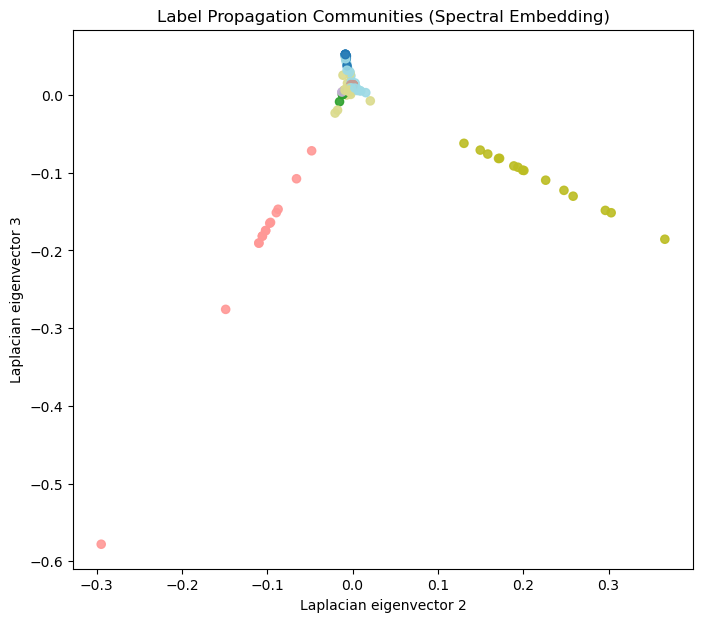

In [7]:
# Degree and Laplacian
degrees = A.sum(axis=1)
L = np.diag(degrees) - A

# Eigen-decomposition
eigvals, eigvecs = np.linalg.eigh(L)

# Use the 2nd and 3rd smallest eigenvectors (skip the first constant one)
coords = eigvecs[:, 1:3]

plt.figure(figsize=(8, 7))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap="tab20", s=35, alpha=0.9)
plt.title("Label Propagation Communities (Spectral Embedding)")
plt.xlabel("Laplacian eigenvector 2")
plt.ylabel("Laplacian eigenvector 3")
plt.show()


## Interpretation

The spectral embedding reveals several distinct clusters of nodes, each colored according to the community label assigned by label propagation. Communities correspond to groups of pages that are more densely connected to each other than to the rest of the graph.

Key observations:

- A few large communities dominate the subgraph, representing dense regions of the Facebook page network.  
- Several smaller communities appear at the periphery, potentially corresponding to niche interest groups or tightly knit page clusters.  
- Nodes lying between communities in the embedding may represent bridge pages that connect different thematic regions of the network.  

Overall, the result illustrates how label propagation can quickly uncover community structure in a large graph using only local neighborhood information.


## Stability across different random seeds

Label propagation is stochastic because it relies on a random update order and random tie-breaking between equally frequent labels. It is therefore useful to check how sensitive the number of detected communities is to the random seed.


In [8]:
seeds = [0, 1, 2, 3, 4, 5]
results = []

for s in seeds:
    model = LabelPropagation(max_iter=1000, seed=s, damping=0.0, tol=0)
    model.fit(A)
    labs = model.predict()
    n_comm = len(np.unique(labs))
    results.append((s, n_comm))

seed_df = pd.DataFrame(results, columns=["seed", "n_communities"])
seed_df


,seed,n_communities
0,0,10
1,1,8
2,2,9
3,3,10
4,4,10
5,5,11


## Discussion of stability and damping

The number of communities is generally stable across different seeds, but small variations can occur due to stochastic tie-breaking. In practice, one can:

- Run label propagation multiple times and either choose the most common partition, or  
- Use damping to reduce label oscillations.

The `damping` parameter in the `LabelPropagation` implementation specifies the probability of keeping the current label rather than adopting the new majority label. Higher damping values can make the algorithm more conservative and may help stabilize the communities at the cost of slower convergence.


## Conclusion

This notebook applied label propagation to a 500-node subgraph of the Facebook page–page network using the `LabelPropagation` class from the `rice2025` package. The workflow included:

1. Constructing an adjacency matrix for a high-degree subgraph.  
2. Running label propagation to detect communities.  
3. Summarizing community sizes.  
4. Visualizing the resulting communities using a Laplacian spectral embedding.  
5. Examining the effect of random seeds on the number of communities.

The example demonstrates how a relatively simple, local update rule can recover meaningful large-scale structure in a real-world social network.
